# Modélisation
## Radiographie Covid-19
### _Asma, Mamaar, Richard_
---

#### Exploration du modèle EfficientNetB7
---

In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling, Resizing, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

Dans ce notebook, nous allons refaire les calculs avec InceptionV3 mais cette fois ci avec l'optimizer Adam à la place de SGD afin de comparer l'impact qu'il peut avoir sur les performances.

In [2]:
train = np.load("train_data_norm.npz")
val = np.load("val_data_norm.npz")
test = np.load("test_data_norm.npz")

X_train = train['X']
y_train = train['y']

X_val = val['X']
y_val = val['y']

X_test = test['X']
y_test = test['y']

mean = train['mean']
std = train['std']
# On passe les images en RGB, necessaire pour le modèle.
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1) if X_train.ndim==3 else np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val[..., np.newaxis], 3, axis=-1) if X_val.ndim==3 else np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1) if X_test.ndim==3 else np.repeat(X_test, 3, axis=-1)

print("Shape de X_train :", X_train.shape)
print("Shape de y_train :", y_train.shape)
print("Shape de X_val :", X_val.shape)
print("Shape de y_val :", y_val.shape)
print("Shape de X_test :", X_test.shape)
print("Shape de y_test :", y_test.shape)
print("Moyenne :", mean)
print("Ecart-type :", std)

Shape de X_train : (7353, 256, 256, 3)
Shape de y_train : (7353,)
Shape de X_val : (1572, 256, 256, 3)
Shape de y_val : (1572,)
Shape de X_test : (1575, 256, 256, 3)
Shape de y_test : (1575,)
Moyenne : 0.10095608
Ecart-type : 0.20103508


In [3]:
X_train = (X_train*std+mean)*255
X_val = (X_val*std+mean)*255
X_test = (X_test*std+mean)*255
# Vérification :
print("Min train :", X_train.min(),"/ Max train :", X_train.max())
print("Min val :", X_val.min(),"/ Max val :", X_val.max())
print("Min test :", X_test.min(),"/ Max test :", X_test.max())

Min train : 0.0 / Max train : 255.0
Min val : 0.0 / Max val : 255.0
Min test : 0.0 / Max test : 255.0


In [17]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)
# Vérifications :
print("Min train :", X_train.min(),"/ Max train :", X_train.max())
print("Min val :", X_val.min(),"/ Max val :", X_val.max())
print("Min test :", X_test.min(),"/ Max test :", X_test.max())

Min train : -1.0 / Max train : 1.0
Min val : -1.0 / Max val : 1.0
Min test : -1.0 / Max test : 1.0


In [18]:
checkpoint = ModelCheckpoint("inceptionv3_adam_covid.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable=False

inputs = Input(shape=(256, 256, 3))
x = Resizing(299,299)(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.2)(x)
outputs = Dense(units=3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32,
                    callbacks = [earlystop, reduce_lr, checkpoint])

with open("history_adam_baseline.json","w") as f:
    json.dump(history_adam.history,f)

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step - accuracy: 0.6646 - loss: 0.7675 - val_accuracy: 0.7284 - val_loss: 0.6663 - learning_rate: 0.0010
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.7337 - loss: 0.6360 - val_accuracy: 0.7214 - val_loss: 0.6313 - learning_rate: 0.0010
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.7476 - loss: 0.6015 - val_accuracy: 0.7653 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.7676 - loss: 0.5749 - val_accuracy: 0.7481 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.7657 - loss: 0.5658 - val_accuracy: 0.7761 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.7680 - loss: 0.5599 - val_accuracy: 0.7672 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.7772 - l

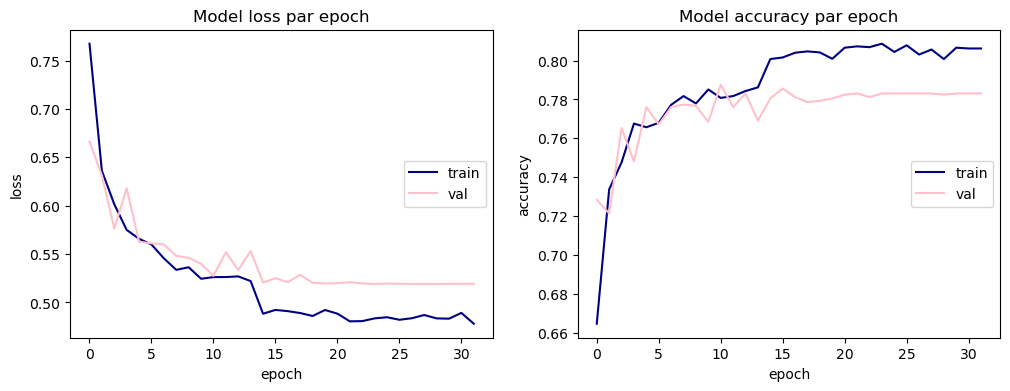

50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
              precision    recall  f1-score   support

        Sain       0.77      0.85      0.81       524
       Covid       0.77      0.74      0.76       524
      Autres       0.82      0.75      0.78       524

    accuracy                           0.78      1572
   macro avg       0.78      0.78      0.78      1572
weighted avg       0.78      0.78      0.78      1572



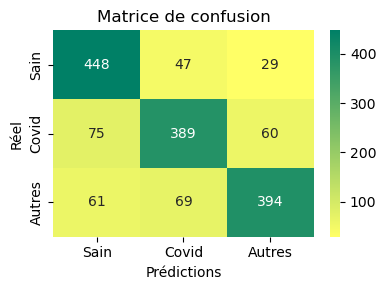

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_adam.history['loss'], color='navy')
plt.plot(history_adam.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_adam.history['accuracy'], color='navy')
plt.plot(history_adam.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred, target_names=noms))
cm_adam = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm_adam, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Les performances pour ce premier calcul sans dégeler les dernieres couches sont similaires à celles obtenues avec l'optimizer Adam.

In [23]:
model = keras.models.load_model("inceptionv3_adam_covid.keras")
base_model = model.layers[2]

for layer in base_model.layers[-50:]:
    layer.trainable=True

for i, layer in enumerate(base_model.layers[-50:]):
    print(i, layer.name, layer.trainable)

checkpoint = ModelCheckpoint("inceptionV3_adam_finetune1_50layers.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_adam_ft1 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32,
                    callbacks = [checkpoint, earlystop, reduce_lr])

with open("history_adam_finetune1_50layers.json","w") as f:
    json.dump(history_adam_ft1.history,f)

0 conv2d_177 True
1 average_pooling2d_16 True
2 conv2d_170 True
3 batch_normalization_172 True
4 batch_normalization_173 True
5 batch_normalization_176 True
6 batch_normalization_177 True
7 conv2d_178 True
8 batch_normalization_170 True
9 activation_172 True
10 activation_173 True
11 activation_176 True
12 activation_177 True
13 batch_normalization_178 True
14 activation_170 True
15 mixed9_0 True
16 concatenate_2 True
17 activation_178 True
18 mixed9 True
19 conv2d_183 True
20 batch_normalization_183 True
21 activation_183 True
22 conv2d_180 True
23 conv2d_184 True
24 batch_normalization_180 True
25 batch_normalization_184 True
26 activation_180 True
27 activation_184 True
28 conv2d_181 True
29 conv2d_182 True
30 conv2d_185 True
31 conv2d_186 True
32 average_pooling2d_17 True
33 conv2d_179 True
34 batch_normalization_181 True
35 batch_normalization_182 True
36 batch_normalization_185 True
37 batch_normalization_186 True
38 conv2d_187 True
39 batch_normalization_179 True
40 activation_1

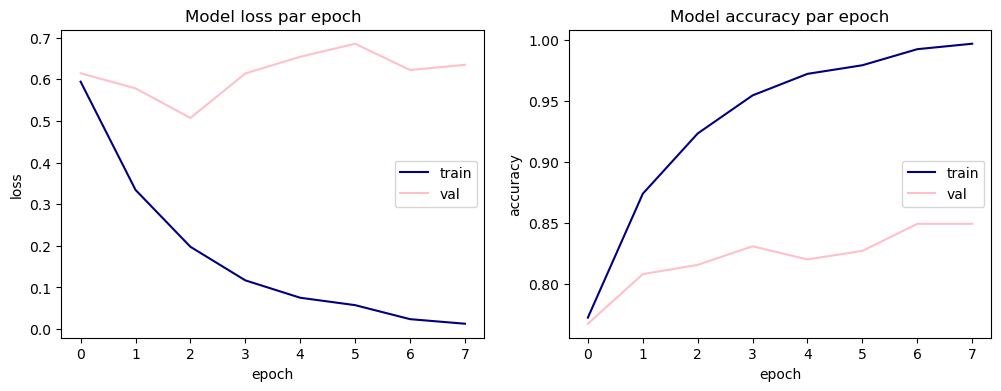

50/50 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step
              precision    recall  f1-score   support

        Sain       0.84      0.84      0.84       524
       Covid       0.87      0.74      0.80       524
      Autres       0.76      0.86      0.81       524

    accuracy                           0.82      1572
   macro avg       0.82      0.82      0.82      1572
weighted avg       0.82      0.82      0.82      1572



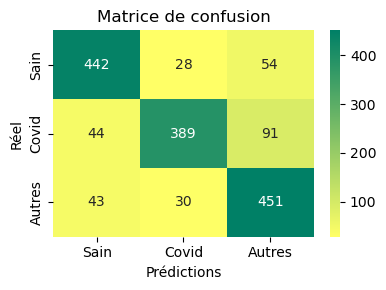

In [24]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_adam_ft1.history['loss'], color='navy')
plt.plot(history_adam_ft1.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_adam_ft1.history['accuracy'], color='navy')
plt.plot(history_adam_ft1.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred, target_names=noms))
cm_adam_ft1 = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm_adam_ft1, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Sur les courbes d'accuracy et de loss on voit qu'il y a un fort overfitting, observé également avec SGD. Mais ici les performances sont quand même plus importantes, même si l'accuracy est de 82%, nous pouvons constater que la précision de la classe Covid est tout de même de 87% malgré un rappel assez bas.

In [25]:
model = keras.models.load_model("inceptionv3_adam_covid.keras")
base_model = model.layers[2]

for layer in base_model.layers[-20:]:
    layer.trainable=True

for i, layer in enumerate(base_model.layers[-20:]):
    print(i, layer.name, layer.trainable)

checkpoint = ModelCheckpoint("inceptionV3_adam_finetune2_20layers.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_adam_ft2 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32,
                    callbacks = [checkpoint, earlystop, reduce_lr])

with open("history_adam_finetune2_20layers.json","w") as f:
    json.dump(history_adam_ft2.history,f)

0 conv2d_185 True
1 conv2d_186 True
2 average_pooling2d_17 True
3 conv2d_179 True
4 batch_normalization_181 True
5 batch_normalization_182 True
6 batch_normalization_185 True
7 batch_normalization_186 True
8 conv2d_187 True
9 batch_normalization_179 True
10 activation_181 True
11 activation_182 True
12 activation_185 True
13 activation_186 True
14 batch_normalization_187 True
15 activation_179 True
16 mixed9_1 True
17 concatenate_3 True
18 activation_187 True
19 mixed10 True
Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.7804 - loss: 0.5561 - val_accuracy: 0.7958 - val_loss: 0.5377 - learning_rate: 1.0000e-04
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 638s 3s/step - accuracy: 0.8195 - loss: 0.4586 - val_accuracy: 0.7977 - val_loss: 0.5009 - learning_rate: 1.0000e-04
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.8418 - loss: 0.3983 - val_accuracy: 0.7831 - val_loss: 0.5362 - learning_rate: 1.0000e-04
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/s

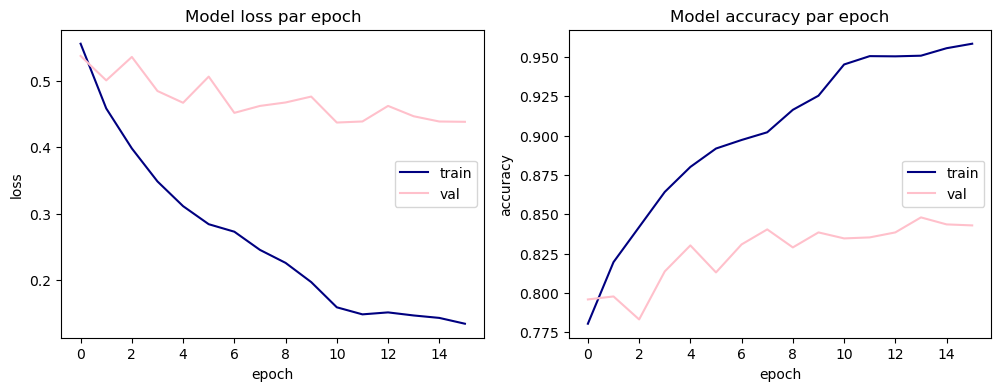

50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
              precision    recall  f1-score   support

        Sain       0.83      0.89      0.86       524
       Covid       0.84      0.81      0.83       524
      Autres       0.83      0.80      0.82       524

    accuracy                           0.83      1572
   macro avg       0.83      0.83      0.83      1572
weighted avg       0.83      0.83      0.83      1572



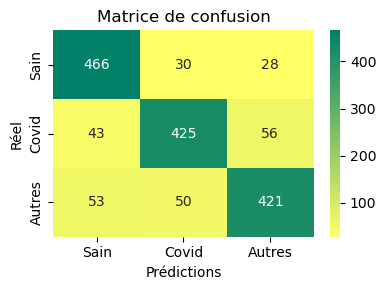

In [26]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_adam_ft2.history['loss'], color='navy')
plt.plot(history_adam_ft2.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_adam_ft2.history['accuracy'], color='navy')
plt.plot(history_adam_ft2.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred, target_names=noms))
cm_adam_ft2 = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm_adam_ft2, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Avec 20 couches dégelées, l'overfitting n'a pas été éliminé même si légèrement réduit. Nous avons perdu un peu de précision sur la classe covid (84%) mais augmenter son rappel. Il y a également un meilleur équilibre entre les classes. L'allure des courbes montre que le modèle n'a pas fini d'apprendre. Nous allons donc ajouter un apprentissage sur 80 epochs pour compléter les 20 epochs précédentes.

In [5]:
model = keras.models.load_model("inceptionV3_adam_finetune2_20layers.keras")

checkpoint = ModelCheckpoint("inceptionV3_adam_finetune3_20layers.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_adam_ft3 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=80, batch_size=32,
                    callbacks = [checkpoint, earlystop, reduce_lr])

with open("history_adam_finetune3_20layers.json","w") as f:
    json.dump(history_adam_ft3.history,f)

Epoch 1/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 778s 3s/step - accuracy: 0.5682 - loss: 1.0712 - val_accuracy: 0.6317 - val_loss: 0.8457 - learning_rate: 1.0000e-04
Epoch 2/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 754s 3s/step - accuracy: 0.6838 - loss: 0.7661 - val_accuracy: 0.6978 - val_loss: 0.7252 - learning_rate: 1.0000e-04
Epoch 3/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 756s 3s/step - accuracy: 0.7133 - loss: 0.6987 - val_accuracy: 0.7328 - val_loss: 0.6600 - learning_rate: 1.0000e-04
Epoch 4/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 4264s 19s/step - accuracy: 0.7421 - loss: 0.6415 - val_accuracy: 0.7576 - val_loss: 0.6097 - learning_rate: 1.0000e-04
Epoch 5/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.7522 - loss: 0.6001 - val_accuracy: 0.6565 - val_loss: 0.9860 - learning_rate: 1.0000e-04
Epoch 6/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.7640 - loss: 0.5748 - val_accuracy: 0.7379 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 7/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - a

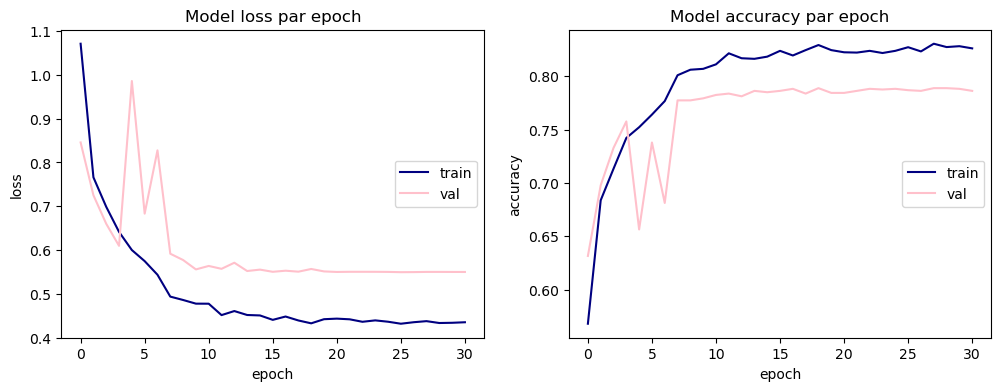

50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
              precision    recall  f1-score   support

        Sain       0.78      0.83      0.80       524
       Covid       0.78      0.76      0.77       524
      Autres       0.81      0.77      0.79       524

    accuracy                           0.79      1572
   macro avg       0.79      0.79      0.79      1572
weighted avg       0.79      0.79      0.79      1572



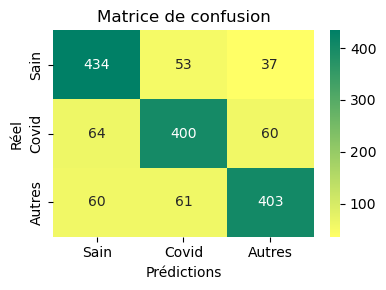

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_adam_ft3.history['loss'], color='navy')
plt.plot(history_adam_ft3.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_adam_ft3.history['accuracy'], color='navy')
plt.plot(history_adam_ft3.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred, target_names=noms))
cm_adam_ft3 = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm_adam_ft3, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

L'augmentation du nombre d'epochs en fine-tuning a entrainé une degradation des performances. Cela confirme que dans notre cas un fine-tuning plus léger (10 à 20 couches) et un nombre limité d'epochs sont mieux adaptés qu'un entrainement prolongé.

50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7797 - loss: 0.5668
Test loss : 0.5668
Test accuracy : 0.7797
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step
              precision    recall  f1-score   support

        Sain       0.76      0.84      0.80       525
       Covid       0.76      0.75      0.75       525
      Autres       0.82      0.75      0.79       525

    accuracy                           0.78      1575
   macro avg       0.78      0.78      0.78      1575
weighted avg       0.78      0.78      0.78      1575



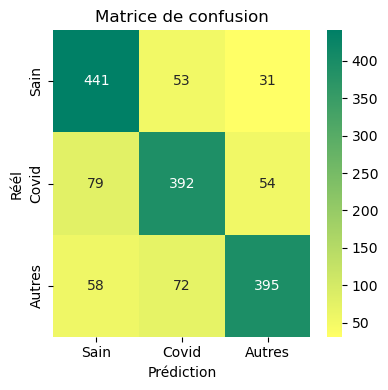

In [9]:
model = load_model("inceptionV3_adam_finetune3_20layers.keras")
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test loss : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")
 
y_proba = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_proba, axis=1)

noms_classes = ["Sain", "Covid", "Autres"]
print(classification_report(y_test, y_pred, target_names=noms_classes))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="summer_r", xticklabels=noms_classes, yticklabels=noms_classes)
plt.xlabel('Prédiction')
plt.ylabel('Réél')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

La différence entre SGD et Adam c'est l'adaptation du learning rate à chaque poids, dans le premier cas le LR reste constant et dans le second le LR est automatiquement adapté. Dans notre cas, ensemble de données assez petit, le modele Adam a tendance à apprendre rapidement puis sur apprendre les données d'entrainement et mal généraliser. On le constate bien dans les premiers entrainement, l'accuracy d'entrainement atteint les 95% alors que l'accuracy de validation reste vers 82%. La vitesse d'apprentissage de l'optimiseur Adam conduit à un sur apprentissage, à l'inverse l'optimiseur SGD est plus lent et donc plus stable.